In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# Load the dataset
file_path = 'yelp_review_cleaned_dataset.csv'
df = pd.read_csv(file_path)

# Limit the size of the dataset
df = df.sample(n=5000, random_state=42)

# Add a dummy 'is_fake' column for demonstration (1 for fake, 0 for genuine)
# In a real scenario, this should come from actual labels
import numpy as np
np.random.seed(42)
df['is_fake'] = np.random.choice([0, 1], size=len(df), p=[0.9, 0.1])

# Display basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 6252 to 2764
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     5000 non-null   object
 1   user_id       5000 non-null   object
 2   business_id   5000 non-null   object
 3   stars         5000 non-null   int64 
 4   useful        5000 non-null   int64 
 5   funny         5000 non-null   int64 
 6   cool          5000 non-null   int64 
 7   text          5000 non-null   object
 8   date          5000 non-null   object
 9   cleaned_text  5000 non-null   object
 10  is_fake       5000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 468.8+ KB


(None,
                    review_id                 user_id             business_id  \
 6252  DXZtkvp3zgHfwOyQ8He0jQ  gatM0_LzUSqNEmlQcBPiBQ  bXjnfT69E8DJinX-ifOofA   
 4684  BRmDLZSJH_YLsbpJ9_VC6Q  dQIgI_eyox_Q4qK0T6iKmA  jLDwSeoQ_kDQwhnUJQO2yw   
 1731  34ZT45dZD_JXbU5rvuyJgg  0xapSfoASxW3pozvAK_DIQ  4nSnvxK-4lKwZvXDGYK5Uw   
 4742  nHwzviHqA97g7341VT2aWw  _GW_i-3PFWZNMjLc_YMXpw  0hIXH9jMdHov1VrLC8ujUg   
 4521  DAe6ffProBgui30TGuFF4g  tGlcQt6syMPeIGKFUXOlmg  1JtpcHELRrSDoWS80WtzuQ   
 
       stars  useful  funny  cool  \
 6252      1       0      0     0   
 4684      3       1      0     0   
 1731      4       3      0     1   
 4742      5       0      0     0   
 4521      5       2      0     0   
 
                                                    text                 date  \
 6252  I can not believe on how unprofessional we wer...  2018-06-19 20:32:28   
 4684  Before one thing got under my skin, I would sa...  2016-07-05 00:10:57   
 1731  This location has been newly re

In [3]:

# Preprocess the cleaned text data
vectorizer = TfidfVectorizer(max_features=300)
text_embeddings = vectorizer.fit_transform(df['cleaned_text']).toarray()

# Encode user_id and business_id
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()
df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])
df['business_id_encoded'] = business_encoder.fit_transform(df['business_id'])

# Number of reviews, users, and businesses
num_reviews = df.shape[0]
num_users = df['user_id_encoded'].nunique()
num_businesses = df['business_id_encoded'].nunique()

# Create a feature matrix for reviews
review_features = torch.tensor(text_embeddings, dtype=torch.float)

# Create placeholder features for users and businesses
user_features = torch.zeros((num_users, review_features.shape[1]))
business_features = torch.zeros((num_businesses, review_features.shape[1]))

# Concatenate all features to create the final feature matrix
features = torch.cat([review_features, user_features, business_features], dim=0)

# Display the encoded IDs and features
print(df[['user_id_encoded', 'business_id_encoded']].head())
print(features.shape)
print(f'Number of reviews: {num_reviews}')
print(f'Number of users: {num_users}')
print(f'Number of businesses: {num_businesses}')


      user_id_encoded  business_id_encoded
6252             3391                 1583
4684             3144                 1910
1731              168                  251
4742             2808                   73
4521             4377                  102
torch.Size([12470, 300])
Number of reviews: 5000
Number of users: 4894
Number of businesses: 2576


In [4]:

# Correctly calculate the total number of nodes
total_nodes = num_reviews + num_users + num_businesses

# Create edge index (connections between nodes)
user_edges = []
business_edges = []

# Create user edges
for idx, row in df.iterrows():
    user_edge = num_reviews + row['user_id_encoded']
    if user_edge < total_nodes:
        user_edges.append([idx, user_edge])
    else:
        raise ValueError(f"User edge index out of bounds: {user_edge}")

# Create business edges
for idx, row in df.iterrows():
    business_edge = num_reviews + num_users + row['business_id_encoded']
    if business_edge < total_nodes:
        business_edges.append([idx, business_edge])
    else:
        raise ValueError(f"Business edge index out of bounds: {business_edge}")

# Combine edges
edges = torch.tensor(user_edges + business_edges, dtype=torch.long).t().contiguous()

# Ensure the edges do not go out of bounds
if edges.max().item() >= total_nodes:
    raise ValueError(f"Edge index out of bounds: {edges.max().item()} >= {total_nodes}")

# Create PyTorch Geometric data object
data = Data(x=features, edge_index=edges)

print(data)


Data(x=[12470, 300], edge_index=[2, 10000])


In [5]:


class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, input_dim)  # Ensure the output dimension matches the input dimension

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model, optimizer, and loss function
input_dim = features.shape[1]
hidden_dim = 64
output_dim = input_dim  # Ensure the output dimension matches the input dimension
model = GNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.x)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.0021162284538149834
Epoch 10, Loss: 0.001256474293768406
Epoch 20, Loss: 0.0012371757766231894
Epoch 30, Loss: 0.0012297163484618068
Epoch 40, Loss: 0.0012271077139303088
Epoch 50, Loss: 0.0012262281961739063
Epoch 60, Loss: 0.0012258506612852216
Epoch 70, Loss: 0.001225738669745624
Epoch 80, Loss: 0.0012256910558789968
Epoch 90, Loss: 0.0012256751069799066
Epoch 100, Loss: 0.0012256677728146315
Epoch 110, Loss: 0.001225665328092873
Epoch 120, Loss: 0.0012256634654477239
Epoch 130, Loss: 0.0012256621848791838
Epoch 140, Loss: 0.0012256611371412873
Epoch 150, Loss: 0.0012256595073267817
Epoch 160, Loss: 0.0012256578775122762
Epoch 170, Loss: 0.0012256556656211615
Epoch 180, Loss: 0.0012256529880687594
Epoch 190, Loss: 0.0012256493791937828


In [6]:
model.eval()
with torch.no_grad():
    embeddings = model(data).detach().numpy()

# Display the embeddings
print(embeddings[:5])

# Evaluate using unsupervised learning metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

sil_score = silhouette_score(embeddings[:num_reviews], df['is_fake'])
calinski_harabasz = calinski_harabasz_score(embeddings[:num_reviews], df['is_fake'])
davies_bouldin = davies_bouldin_score(embeddings[:num_reviews], df['is_fake'])

print(f'Silhouette Score: {sil_score}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(f'Davies-Bouldin Index: {davies_bouldin}')

# Count the number of fake reviews identified
num_fake_reviews = df['is_fake'].sum()
print(f'Number of fake reviews: {num_fake_reviews}')

# Assume the first dimension of embeddings can be used for thresholding
threshold = embeddings[:, 0].mean()

# Predict fake reviews based on the threshold
predicted_is_fake = (embeddings[:, 0] > threshold).astype(int)

# Calculate accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df['is_fake'], predicted_is_fake[:num_reviews])
accuracy_percentage = accuracy * 100

print(f'Accuracy: {accuracy_percentage:.2f}%')


[[0.00816138 0.00228242 0.00551196 ... 0.00308901 0.02198341 0.00749411]
 [0.00816138 0.00228242 0.00551196 ... 0.00308901 0.02198341 0.00749411]
 [0.00816138 0.00228242 0.00551196 ... 0.00308901 0.02198341 0.00749411]
 [0.00816138 0.00228242 0.00551196 ... 0.00308901 0.02198341 0.00749411]
 [0.00816138 0.00228242 0.00551196 ... 0.00308901 0.02198341 0.00749411]]
Silhouette Score: -0.8078001737594604
Calinski-Harabasz Index: 0.13674724844991973
Davies-Bouldin Index: 2.449881807821122
Number of fake reviews: 479
Accuracy: 90.36%


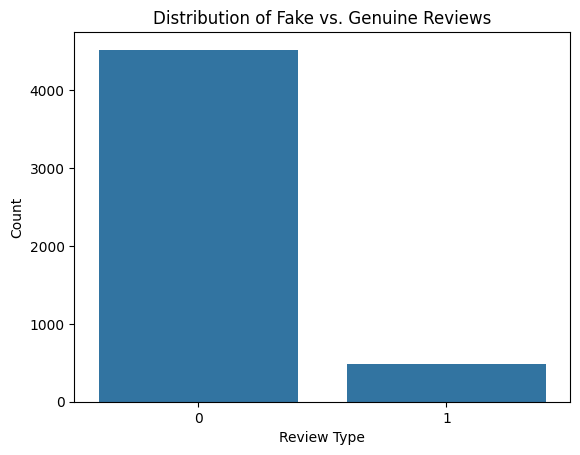

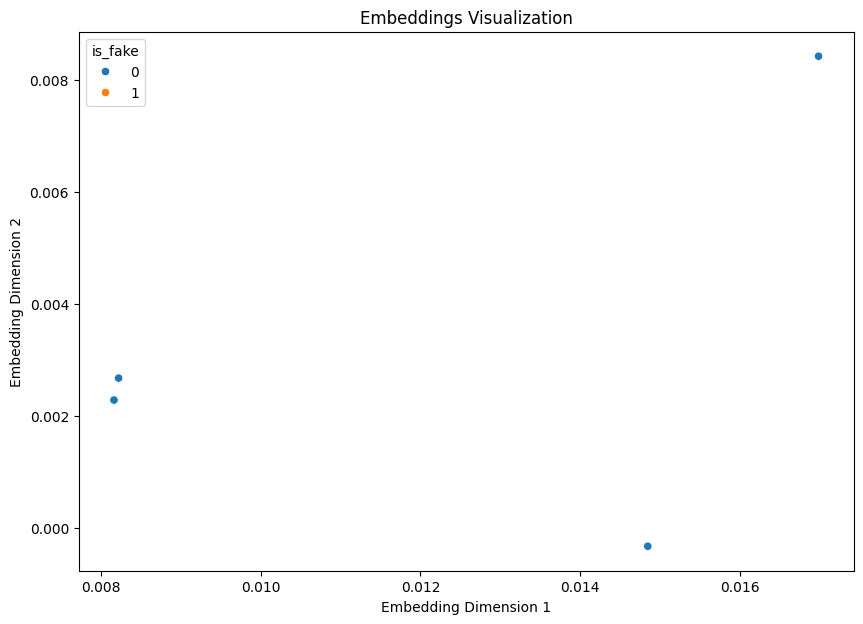

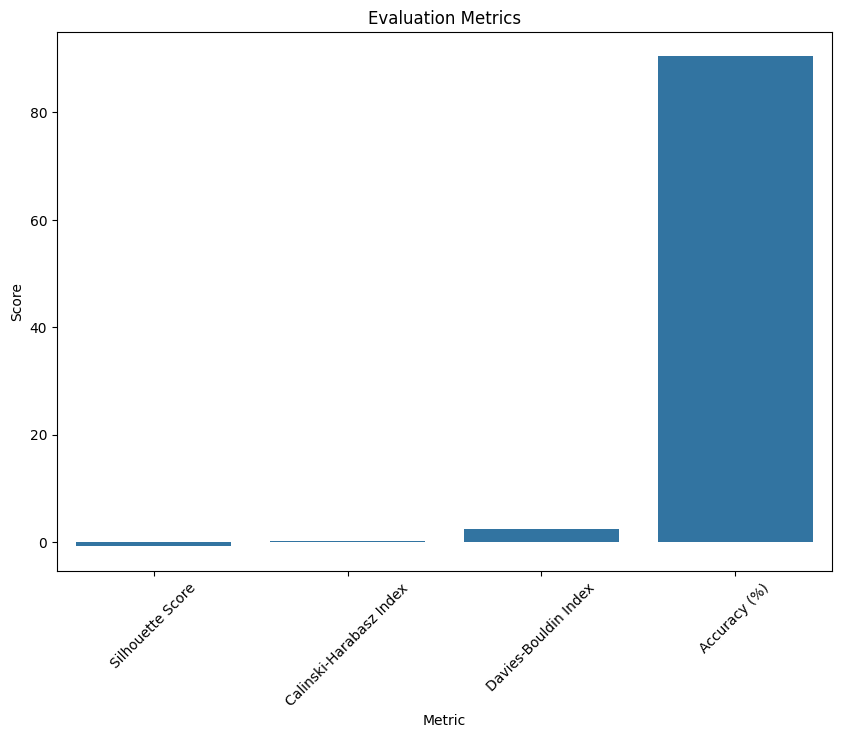

In [7]:

# Visualize the distribution of fake vs. genuine reviews
sns.countplot(x='is_fake', data=df)
plt.title('Distribution of Fake vs. Genuine Reviews')
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.show()

# Visualize the embeddings
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings[:num_reviews, 0], y=embeddings[:num_reviews, 1], hue=df['is_fake'])
plt.title('Embeddings Visualization')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.show()

# Visualize the evaluation metrics
metrics = {
    'Silhouette Score': sil_score,
    'Calinski-Harabasz Index': calinski_harabasz,
    'Davies-Bouldin Index': davies_bouldin,
    'Accuracy (%)': accuracy_percentage
}

plt.figure(figsize=(10, 7))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()
